In [116]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
import torch.optim as optim

This is adapted from chapter 6 Deep learning with Pytorch book. We will look at how Pytorch nn module works.

## Lets get the data

In [117]:
train = pd.read_csv('../input/celsius-to-fahrenheit/training.csv')
train.head()

,Celsius,Fahrenheit
0,1169,2136.2
1,1280,2336.0
2,2380,4316.0
3,1508,2746.4
4,2015,3659.0


In [118]:
t_c = list(train['Celsius'])
t_u = list(train['Fahrenheit'])

t_c[:5], t_u[:5]

([1169, 1280, 2380, 1508, 2015], [2136.2, 2336.0, 4316.0, 2746.4, 3659.0])


t_u and t_c were two 1D tensors of size B. In a linear model, no neural network, Thanks
to broadcasting, we could write our linear model as w * x + b, where w and b were
two scalar parameters.

This worked because we had a single input feature: if we had
two, we would need to add an extra dimension to turn that 1D tensor into a matrix
with samples in the rows and features in the columns.

That’s exactly what we need to do to switch to using nn.Linear. We reshape our B
inputs to B × Nin, where Nin is 1. That is easily done with unsqueeze:

In [119]:
t_c = torch.tensor(t_c).unsqueeze(1)
t_u = torch.tensor(t_u).unsqueeze(1)

In [120]:
t_c[:5], t_u[:5], t_u.shape, t_c.shape

(tensor([[1169],
         [1280],
         [2380],
         [1508],
         [2015]]),
 tensor([[2136.2000],
         [2336.0000],
         [4316.0000],
         [2746.3999],
         [3659.0000]]),
 torch.Size([16000, 1]),
 torch.Size([16000, 1]))

## training and validation set

In [121]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([13882,  5473,  9184,  ...,  2406,  8493,  4364]),
 tensor([ 1618, 11815,  3393,  ...,  5815,  9395,  9331]))

In [122]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]


normalising the values

In [123]:
t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

In [124]:
# t_cn_train = 0.1 * t_c_train
# t_cn_val = 0.1 * t_c_val

t_cn_train = t_c_train
t_cn_val = t_c_val

In [125]:
t_cn_train, t_cn_val = t_cn_train.type(torch.FloatTensor), t_cn_val.type(torch.FloatTensor)


In [126]:
type(t_cn_train), type(t_c_val)

(torch.Tensor, torch.Tensor)

In [127]:
t_cn_train[:5], t_un_train[:5]

(tensor([[1979.],
         [1393.],
         [ 313.],
         [1985.],
         [2173.]]),
 tensor([[359.4200],
         [253.9400],
         [ 59.5400],
         [360.5000],
         [394.3400]]))

# The Pytorch nn module

 PyTorch has a whole submodule dedicated to neural networks, called torch.nn. It
contains the building blocks needed to create all sorts of neural network architectures. Those building blocks are called modules in PyTorch parlance (such building
blocks are often referred to as layers in other frameworks). A PyTorch module is a
Python class deriving from the nn.Module base class. A module can have one or more
Parameter instances as attributes, which are tensors whose values are optimized
during the training process (think w and b in our linear model). A module can also
have one or more submodules (subclasses of nn.Module) as attributes, and it will be
able to track their parameters as well.

In [128]:
import torch.nn as nn

All PyTorch-provided subclasses of nn.Module have their __call__ method defined.
This allows us to instantiate an nn.Linear and call it as if it was a function, 

note: The submodules must be top-level attributes, not buried inside list or
dict instances! Otherwise, the optimizer will not be able to locate the submodules (and, hence, their parameters). For situations where your model
requires a list or dict of submodules, PyTorch provides nn.ModuleList and
nn.ModuleDict.

All PyTorch-provided subclasses of nn.Module have their __call__ method defined.
This allows us to instantiate an nn.Linear and call it as if it was a function, like so


In [129]:
linear_model = nn.Linear(1,1)
# linear model accepts 3 : input size, output size and bias defaults to True
linear_model(t_un_val)

tensor([[103.3914],
        [ 68.4414],
        [ 23.4248],
        ...,
        [ 73.4529],
        [ 15.7986],
        [ 66.5675]], grad_fn=<AddmmBackward>)

Aside : Calling an instance of nn.Module with a set of arguments ends up calling a method
named forward with the same arguments. The forward method is what executes the
forward computation, while __call__ does other rather important chores before and
after calling forward. So, it is technically possible to call forward directly, and it will
produce the same output as __call__, but this should not be done from user code:

`y = model(x)` correct

`y = model.forward(x)` wrong

In [130]:
linear_model.weight

Parameter containing:
tensor([[0.2421]], requires_grad=True)

In [131]:
linear_model.bias

Parameter containing:
tensor([0.2508], requires_grad=True)

In [132]:
## calling the module with some input

linear_model(torch.ones(1))

tensor([0.4929], grad_fn=<AddBackward0>)

Although PyTorch lets us get away with it, we don’t actually provide an input with the
right dimensionality. We have a model that takes one input and produces one output,
but PyTorch nn.Module and its subclasses are designed to do so on multiple samples at
the same time. To accommodate multiple samples, modules expect the zeroth dimension of the input to be the number of samples in the batch.

## Batching inputs

Any module in nn is written to produce outputs for a batch of multiple inputs at the
same time. Thus, assuming we need to run nn.Linear on 10 samples, we can create an
input tensor of size B × Nin, where B is the size of the batch and Nin is the number of
input features, and run it once through the model. For example:

In [133]:
linear_model(torch.ones(10,1))

# since there is no loss and update the values are same

tensor([[0.4929],
        [0.4929],
        [0.4929],
        [0.4929],
        [0.4929],
        [0.4929],
        [0.4929],
        [0.4929],
        [0.4929],
        [0.4929]], grad_fn=<AddmmBackward>)

Our input is B × C × H × W with a batch size of 3 (say, images of a dog, a bird, and then a car), three channel dimensions (red, green, and blue),
and an unspecified number of pixels for height and width. As we can see, the output is a tensor of size B × Nout, where Nout is the number of output features: four, in
this case.

## Optimising batches

The reason we want to do this batching is multifaceted. One big motivation is to make
sure the computation we’re asking for is big enough to saturate the computing
resources we’re using to perform the computation. GPUs in particular are highly parallelized, so a single input on a small model will leave most of the computing units idle.
By providing batches of inputs, the calculation can be spread across the otherwise-idle
units, which means the batched results come back just as quickly as a single result
would. Another benefit is that some advanced models use statistical information from
the entire batch, and those statistics get better with larger batch sizes.

lets pass te linear model (parameters) to optimizer:

In [134]:
linear_model = nn.Linear(1,1)

In [135]:
optimizer = optim.SGD(
    linear_model.parameters(),
    lr=1e-2
)

Usually, it was our responsibility to create parameters and pass them as the first argument to optim.SGD. Now we can use the parameters method to ask any nn.Module for
a list of parameters owned by it or any of its submodules:

In [136]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[-0.6114]], requires_grad=True),
 Parameter containing:
 tensor([0.7395], requires_grad=True)]

This call recurses into submodules defined in the module’s init constructor and
returns a flat list of all parameters encountered, so that we can conveniently pass it to
the optimizer constructor as we did previously.

We can already figure out what happens in the training loop. The optimizer is provided with a list of tensors that were defined with requires_grad = True—all Parameters
are defined this way by definition, since they need to be optimized by gradient descent.

When training_loss.backward() is called, grad is accumulated on the leaf nodes of the
graph, which are precisely the parameters that were passed to the optimizer.

 At this point, the SGD optimizer has everything it needs. When optimizer.step()
is called, it will iterate through each Parameter and change it by an amount proportional to what is stored in its grad attribute. Pretty clean design.
 Let’s take a look a the training loop now:

In [137]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val, t_c_train, t_c_val, output_freq):
    print("for t_u_train : ", t_u_train )
    print("for t_c_train : ", t_c_train)
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train)
        loss_train = loss_fn(t_p_train, t_c_train)
        
        t_p_val = model(t_u_val)
        loss_val = loss_fn(t_p_val, t_c_val )
        
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        
    
        if epoch ==1 or epoch % output_freq == 0:
            print("predicted t_p_train : ", t_p_train)
            print("Epoch: ", epoch, " Training loss: ", loss_train.item(), " Val loss:", loss_val.item())

It hasn’t changed practically at all, except that now we don’t pass params explicitly to
model since the model itself holds its Parameters internally.
 There’s one last bit that we can leverage from torch.nn: the loss. Indeed, nn comes
with several common loss functions, among them nn.MSELoss (MSE stands for Mean
Square Error), which is exactly what we defined earlier as our loss_fn. Loss functions
in nn are still subclasses of nn.Module, so we will create an instance and call it as a
function. In our case, we get rid of the handwritten loss_fn and replace it.

### debug

my loss values were comingtoo high inf

In [138]:
t_un_train

tensor([[359.4200],
        [253.9400],
        [ 59.5400],
        ...,
        [154.0400],
        [ 66.9200],
        [358.5200]])

In [139]:
t_cn_train

tensor([[1979.],
        [1393.],
        [ 313.],
        ...,
        [ 838.],
        [ 354.],
        [1974.]])

In [140]:
torch.ones(5)

tensor([1., 1., 1., 1., 1.])

In [141]:
linear_model = nn.Linear(1,1)
linear_model

Linear(in_features=1, out_features=1, bias=True)

In [142]:
linear_model(torch.ones(1))

tensor([0.7320], grad_fn=<AddBackward0>)

In [143]:
a = [0,1,1]
b = [1,1,1]

a = torch.tensor(a).unsqueeze(1)
b = torch.tensor(b).unsqueeze(1)

a,b=a.type(torch.FloatTensor),b.type(torch.FloatTensor)

In [144]:
# TRYING OUT LOSS FUNCTION
t_p_train = linear_model(a)
print(t_p_train)

test_loss= nn.MSELoss()
test_loss(t_p_train, b)

tensor([[-0.2643],
        [ 0.7320],
        [ 0.7320]], grad_fn=<AddmmBackward>)


tensor(0.5807, grad_fn=<MseLossBackward>)

In [145]:
linear_model= nn.Linear(1,1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-5)

training_loop(
    n_epochs = 3000,
    optimizer = optimizer,
    model = linear_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val,
    t_c_train = t_cn_train,
    t_c_val = t_cn_val,
    output_freq = 1000
)

print()
print(linear_model.weight)
print(linear_model.bias)

for t_u_train :  tensor([[359.4200],
        [253.9400],
        [ 59.5400],
        ...,
        [154.0400],
        [ 66.9200],
        [358.5200]])
for t_c_train :  tensor([[1979.],
        [1393.],
        [ 313.],
        ...,
        [ 838.],
        [ 354.],
        [1974.]])
predicted t_p_train :  tensor([[336.1199],
        [237.5057],
        [ 55.7593],
        ...,
        [144.1083],
        [ 62.6590],
        [335.2785]], grad_fn=<AddmmBackward>)
Epoch:  1  Training loss:  1452871.25  Val loss: 1426310.5
predicted t_p_train :  tensor([[1975.7488],
        [1395.9268],
        [ 327.3132],
        ...,
        [ 846.7781],
        [ 367.8810],
        [1970.8013]], grad_fn=<AddmmBackward>)
Epoch:  1000  Training loss:  77.36172485351562  Val loss: 79.86121368408203
predicted t_p_train :  tensor([[1975.7644],
        [1395.9124],
        [ 327.2435],
        ...,
        [ 846.7354],
        [ 367.8134],
        [1970.8168]], grad_fn=<AddmmBackward>)
Epoch:  2000  Training

Got an answer! 

Note if you are getting inf as the training loss, play with learning rate, it might be too high.

### Replacing the model

We are going to keep everything else fixed, including the loss function, and only redefine model. Let’s build the simplest possible neural network: a linear module, followed
by an activation function, feeding into another linear module.

In [146]:
seq_model = nn.Sequential(
            nn.Linear(1,13),
    # 13 was chosen arbitrarly
            nn.Tanh(),
            nn.Linear(13,1)
)

seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

In [147]:
seq_model.parameters()

<generator object Module.parameters at 0x7fddfc443650>

In [148]:
[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

These are the tensors that the optimizer will get. Again, after we call model.backward(),
all parameters are populated with their grad, and the optimizer then updates their values accordingly during the optimizer.step() call. Not that different from our previous
linear model, eh? After all, they’re both differentiable models that can be trained using
gradient descent.
 A few notes on parameters of nn.Modules. When inspecting parameters of a model
made up of several submodules, it is handy to be able to identify parameters by name.
There’s a method for that, called named_parameters:

In [149]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


The name of each module in Sequential is just the ordinal with which the module
appears in the arguments. Interestingly, Sequential also accepts an OrderedDict,in
which we can name each module passed to Sequential:

In [150]:
from collections import OrderedDict

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1,8)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(8,1))
]))

seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

This allows us to get more explanatory names for submodules:

In [151]:
for name, param  in seq_model.named_parameters():
    print(name, param.shape)

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


This is more descriptive; but it does not give us more flexibility in the flow of data
through the network, which remains a purely sequential pass-through—the
nn.Sequential is very aptly named. We will see how to take full control of the processing of input data by subclassing nn.Module ourselves in chapter 8.
 We can also access a particular Parameter by using submodules as attributes:


In [152]:
seq_model.output_linear.bias

Parameter containing:
tensor([-0.0165], requires_grad=True)

This is useful for inspecting parameters or their gradients: for instance, to monitor
gradients during training, as we did at the beginning of this chapter. Say we want to
print out the gradients of weight of the linear portion of the hidden layer. We can run
the training loop for the new neural network model and then look at the resulting
gradients after the last epoch:


In [153]:
optimizer = optim.SGD(seq_model.parameters(), lr = 1e-3)

training_loop(
    n_epochs=5000,
    optimizer=optimizer,
    model=seq_model,
    loss_fn=nn.MSELoss(),
    t_u_train=t_un_train,
    t_u_val=t_un_val,
    t_c_train=t_cn_train,
    t_c_val=t_cn_val,
    output_freq = 1000
)


for t_u_train :  tensor([[359.4200],
        [253.9400],
        [ 59.5400],
        ...,
        [154.0400],
        [ 66.9200],
        [358.5200]])
for t_c_train :  tensor([[1979.],
        [1393.],
        [ 313.],
        ...,
        [ 838.],
        [ 354.],
        [1974.]])
predicted t_p_train :  tensor([[0.3274],
        [0.3274],
        [0.3274],
        ...,
        [0.3274],
        [0.3274],
        [0.3274]], grad_fn=<AddmmBackward>)
Epoch:  1  Training loss:  2108779.25  Val loss: 2070260.0
predicted t_p_train :  tensor([[1258.3866],
        [1258.3866],
        [1258.3866],
        ...,
        [1258.3866],
        [1258.3866],
        [1258.3866]], grad_fn=<AddmmBackward>)
Epoch:  1000  Training loss:  526061.5  Val loss: 533492.1875
predicted t_p_train :  tensor([[1258.3881],
        [1258.3881],
        [1258.3881],
        ...,
        [1258.3881],
        [1258.3881],
        [1258.3881]], grad_fn=<AddmmBackward>)
Epoch:  2000  Training loss:  526061.5  Val loss:

In [154]:
print('Output', seq_model(t_un_val))
print('Answer', t_c_val)
print('hidden', seq_model.hidden_linear.weight.grad)

Output tensor([[1258.3881],
        [1258.3881],
        [1258.3881],
        ...,
        [1258.3881],
        [1258.3881],
        [1258.3881]], grad_fn=<AddmmBackward>)
Answer tensor([[2349],
        [1547],
        [ 514],
        ...,
        [1662],
        [ 339],
        [1504]])
hidden tensor([[ 0.0000],
        [ 0.0000],
        [-0.0233],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000]])


### Comparing to a linear model

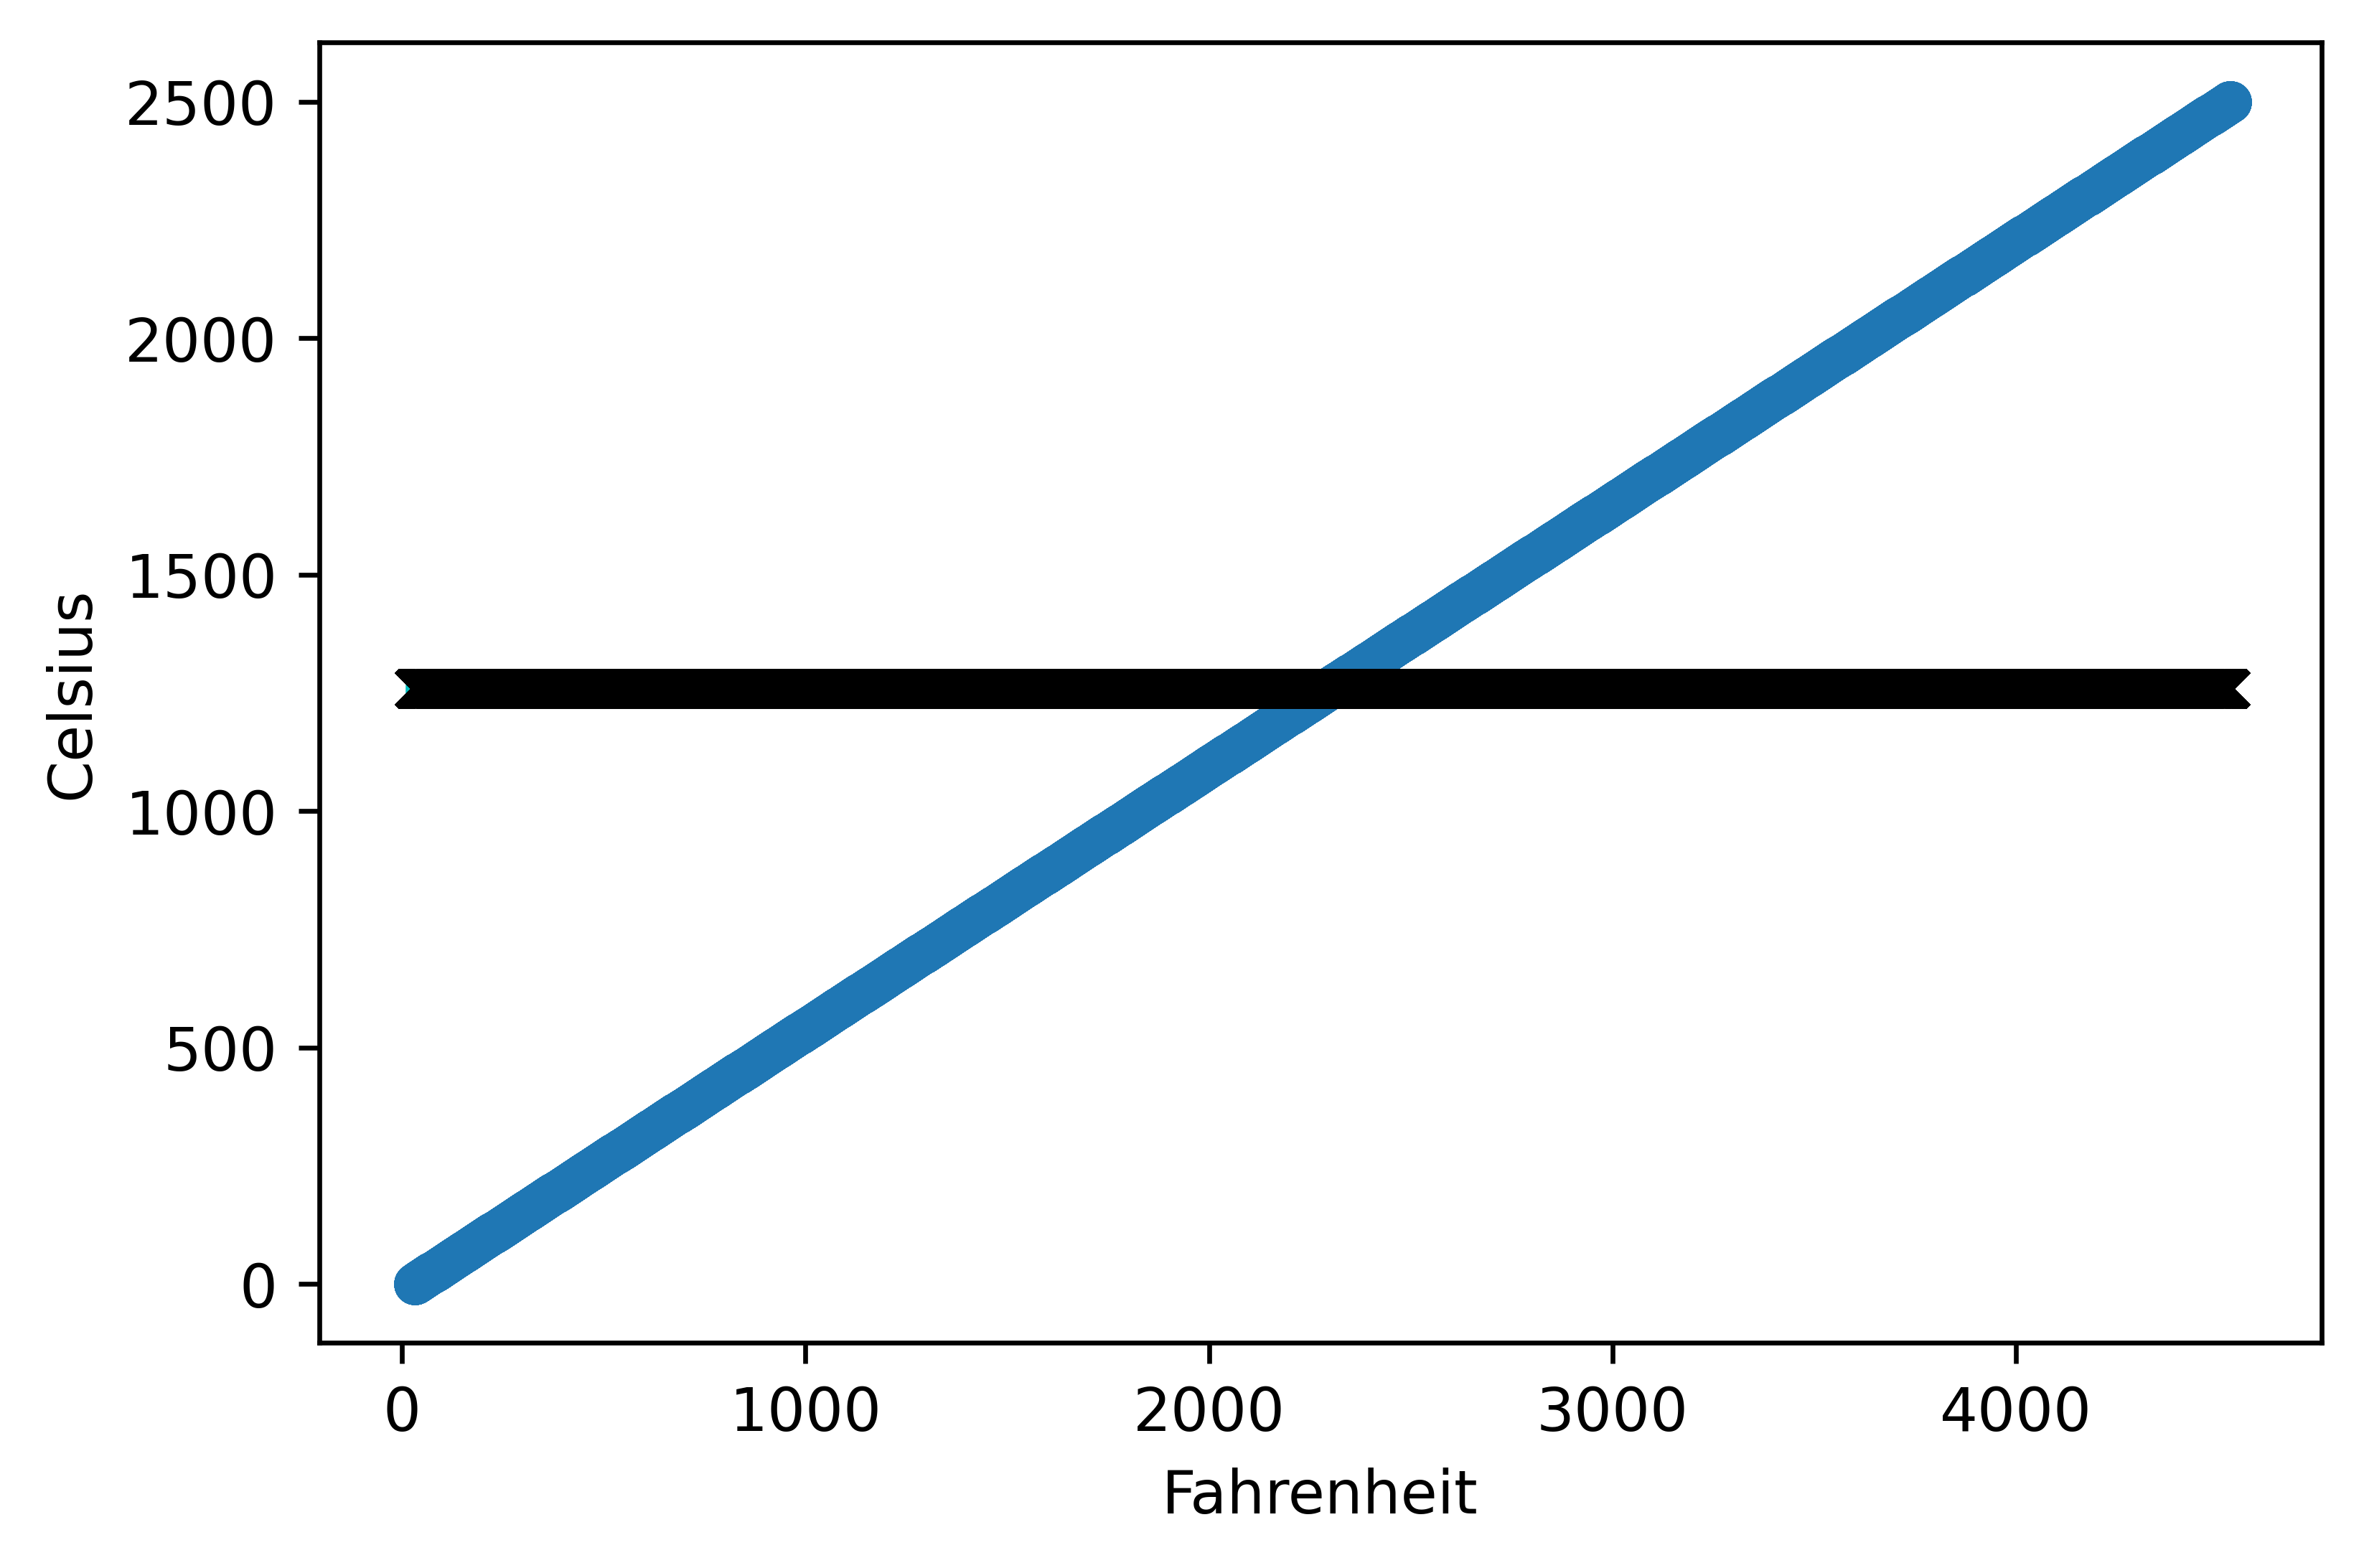

In [155]:
from matplotlib import pyplot as plt

t_range = torch.arange(20.,90.).unsqueeze(1)

fig = plt.figure(dpi=600)

plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')

for linear model

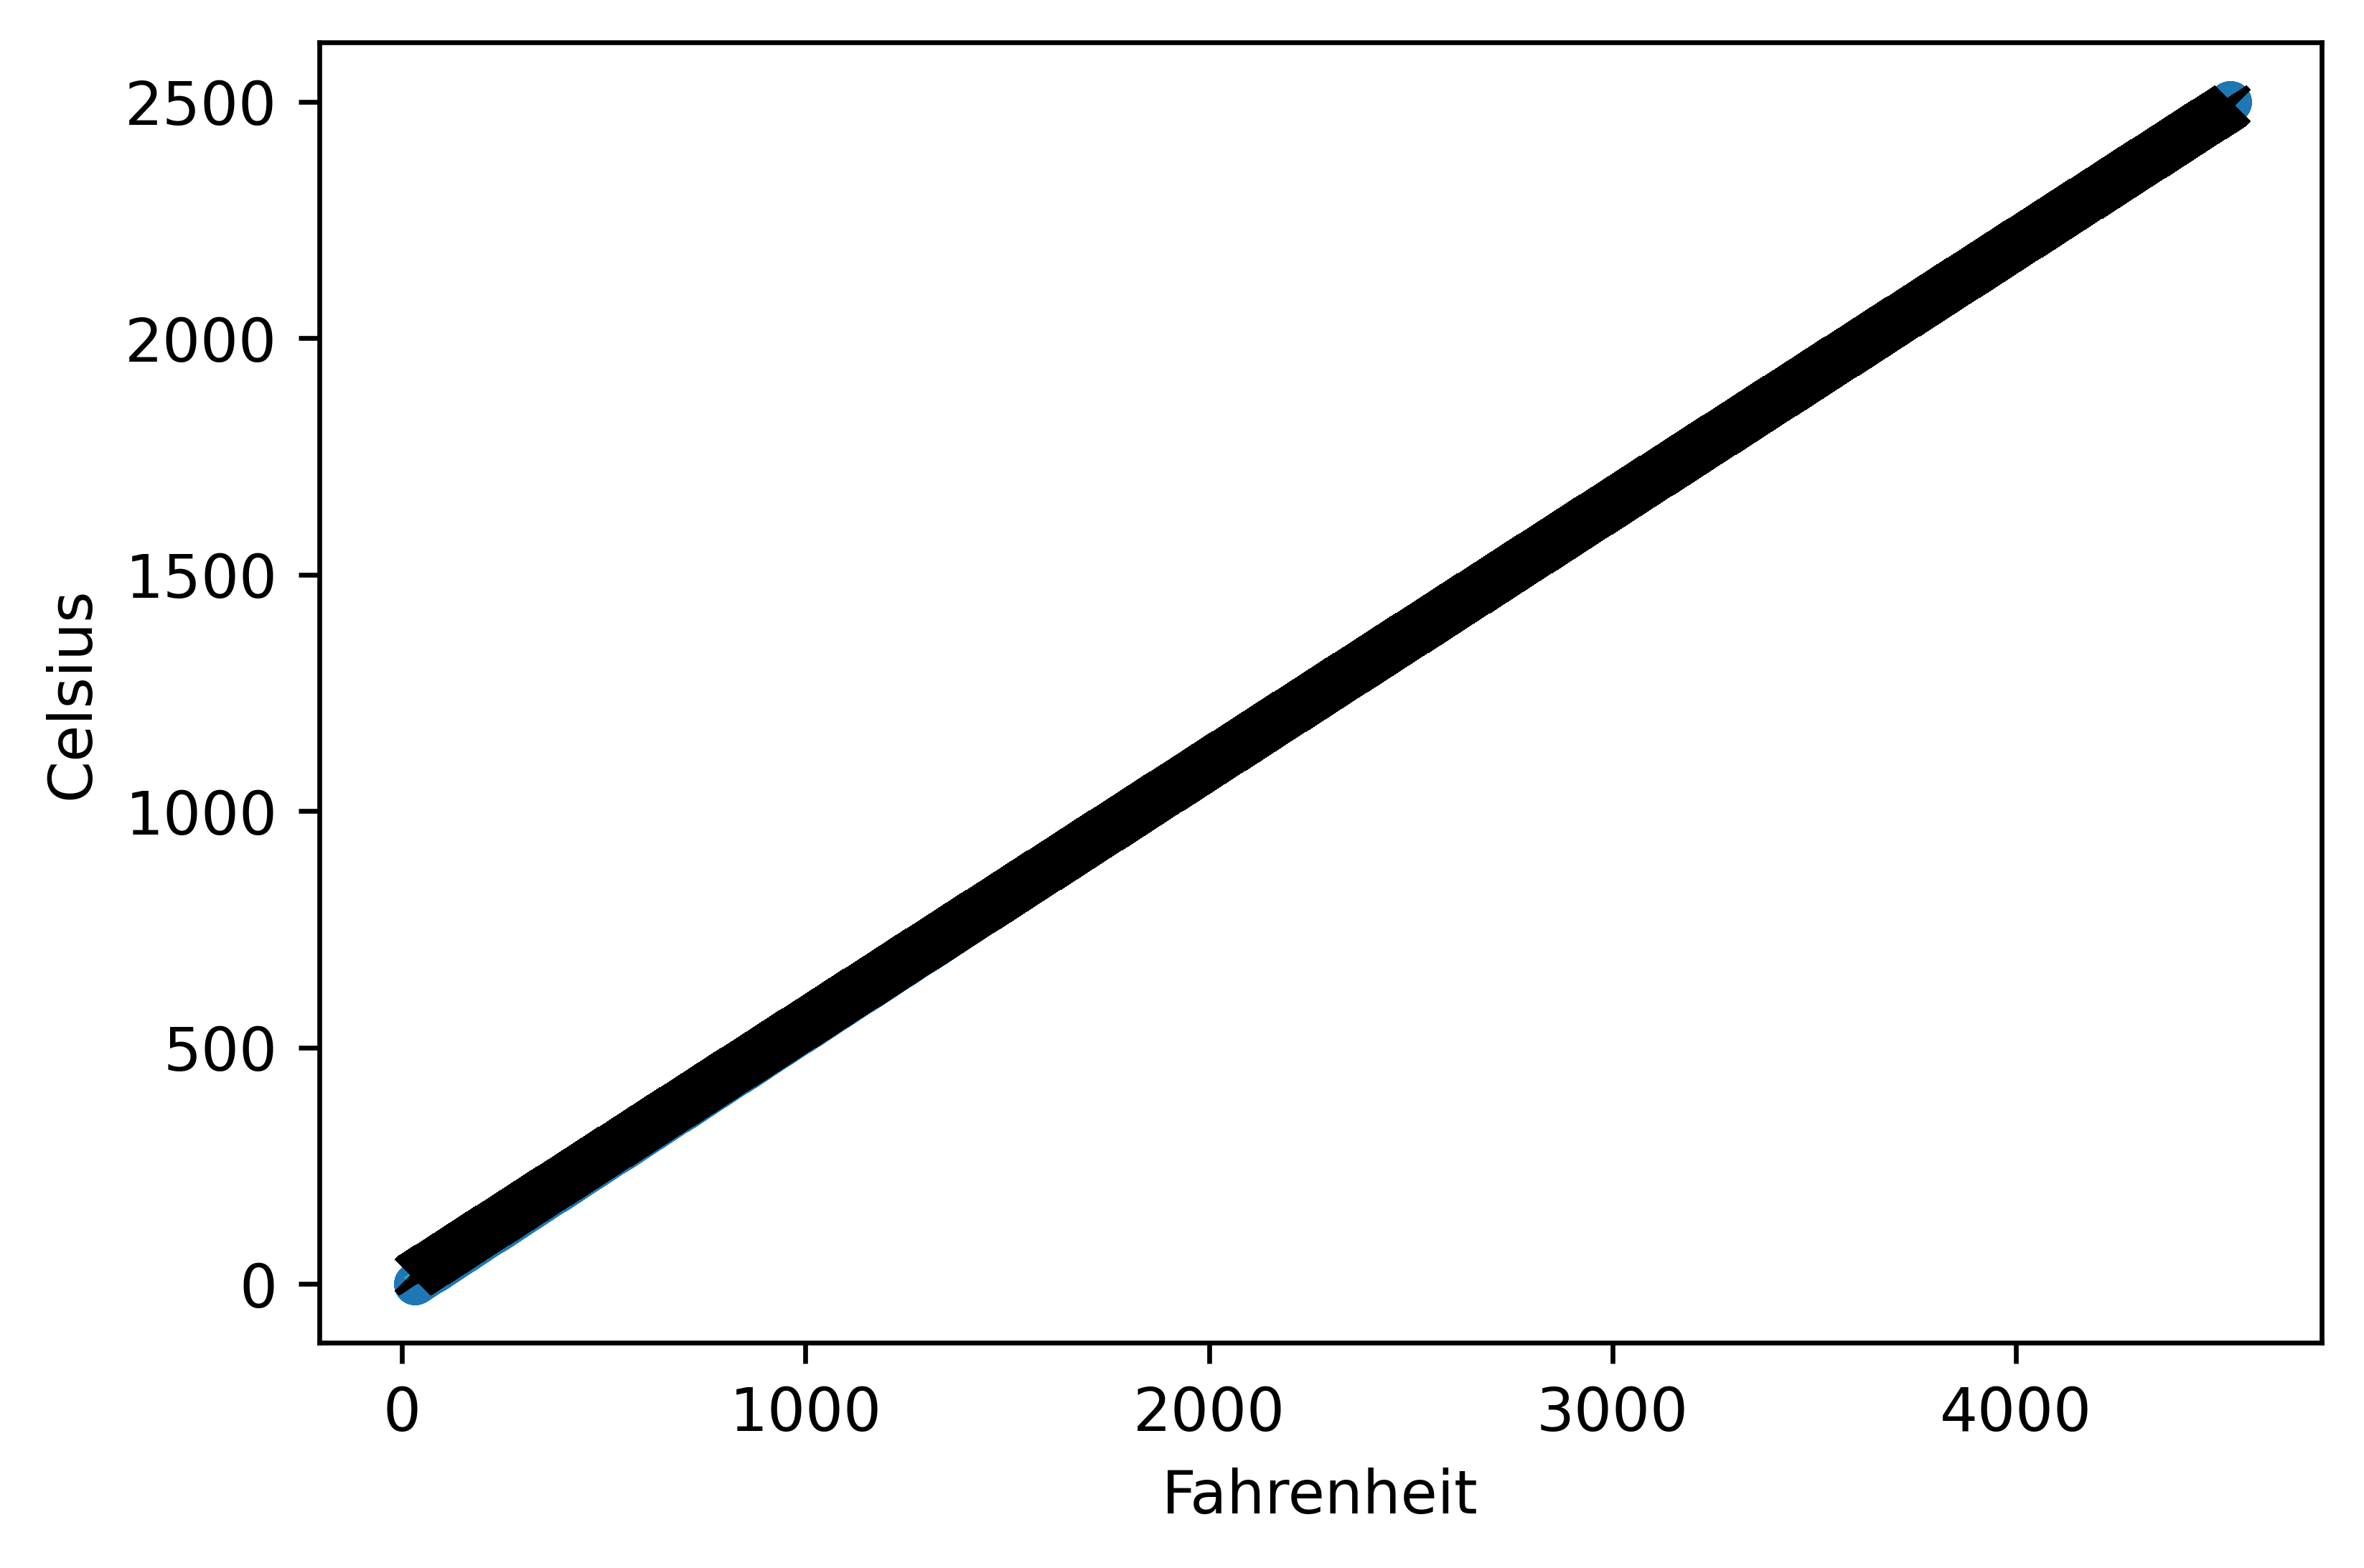

In [156]:
from matplotlib import pyplot as plt

t_range = torch.arange(20.,90.).unsqueeze(1)

fig = plt.figure(dpi=600)

plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), linear_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), linear_model(0.1 * t_u).detach().numpy(), 'kx')

. By now you should
have confidence in your understanding of what’s going on behind the scenes. Hopefully this taste of PyTorch has given you an appetite for mo

# Exercises

1. Experiment with the number of hidden neurons in our simple neural network
model, as well as the learning rate.

In [157]:
# lets get data

import pandas as pd

train = pd.read_csv("../input/celsius-to-fahrenheit/training.csv")
train.head()

,Celsius,Fahrenheit
0,1169,2136.2
1,1280,2336.0
2,2380,4316.0
3,1508,2746.4
4,2015,3659.0


In [158]:
t_c = list(train['Celsius'])
t_u = list(train['Fahrenheit'])

t_c[:5], t_u[:5]

([1169, 1280, 2380, 1508, 2015], [2136.2, 2336.0, 4316.0, 2746.4, 3659.0])

In [159]:
import torch

In [160]:
t_c = torch.tensor(t_c).unsqueeze(1)
t_u = torch.tensor(t_u).unsqueeze(1)


In [161]:
t_c[:5], t_u[:5]

(tensor([[1169],
         [1280],
         [2380],
         [1508],
         [2015]]),
 tensor([[2136.2000],
         [2336.0000],
         [4316.0000],
         [2746.3999],
         [3659.0000]]))

In [162]:
t_c.shape, t_u.shape

(torch.Size([16000, 1]), torch.Size([16000, 1]))

In [163]:
t_c, t_u = t_c.type(torch.FloatTensor), t_u.type(torch.FloatTensor)


In [164]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([ 2640,  5754,  1986,  ..., 15013,  7955, 11029]),
 tensor([13677,  2971,  3653,  ...,  7857,  5640,  9168]))

In [165]:
# validation set creation and normalization

t_un_train = t_u[train_indices] * 0.1
t_un_val = t_u[val_indices] * 0.1

t_c_train = t_c[train_indices] 
t_c_val = t_c[val_indices] 

In [166]:
# lets create a model from scratch


seq_model = torch.nn.Sequential(
    torch.nn.Linear(1, 17),
    torch.nn.Tanh(),
    torch.nn.Linear(17,1)
)

In [167]:
[param.shape for param in seq_model.parameters()]

[torch.Size([17, 1]), torch.Size([17]), torch.Size([1, 17]), torch.Size([1])]

In [168]:
optimizer = torch.optim.SGD(seq_model.parameters(), lr=1e-4)

In [169]:
t_un_train.shape, t_c_train.shape

(torch.Size([12800, 1]), torch.Size([12800, 1]))

In [170]:
def training_loop(n_epochs=5000, optimizer=optimizer,model=seq_model,loss_fn=torch.nn.MSELoss(), train_t_u=t_un_train, val_t_u=t_un_val, train_t_c=t_c_train, val_t_c = t_c_val):
    for epoch in range(1, n_epochs +1):
        train_t_p = model(train_t_u)
        train_loss = loss_fn(train_t_p, train_t_c)
        
        with torch.no_grad():
            val_t_p = model(val_t_u)
            val_loss = loss_fn(val_t_p, val_t_c)
            assert val_loss.requires_grad == False
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        if (epoch %1000 == 0):
            print('training_loss: ', train_loss, 'validation_loss: ',val_loss)

In [171]:
training_loop()

training_loss:  tensor(530559.5000, grad_fn=<MseLossBackward>) validation_loss:  tensor(515452.4062)
training_loss:  tensor(530552.7500, grad_fn=<MseLossBackward>) validation_loss:  tensor(515462.6250)
training_loss:  tensor(530552.7500, grad_fn=<MseLossBackward>) validation_loss:  tensor(515462.5625)
training_loss:  tensor(530552.6250, grad_fn=<MseLossBackward>) validation_loss:  tensor(515462.4062)
training_loss:  tensor(530552.7500, grad_fn=<MseLossBackward>) validation_loss:  tensor(515462.6250)
